In [53]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns

#https://towardsdatascience.com/anova-tukey-test-in-python-b3082b6e6bda
experiment_names = ['owl_exp_pure',
                    'owl_exp_mixed',
                    'strike_exp_pure',
                    'strike_exp_mixed',
                    'energy_gain_pure',
                    'energy_gain_mixed',
                    ]

def query_exp_data(label):
    total_exp_data=[]
    for i in range(1,7):
        file_path_totals = '/home/mremington/Documents/uumarrty_exps/{}/exp{}/Data/totals.csv'.format(label,i)
        temp_exp_total = pd.read_csv(file_path_totals,header = 0, index_col=None)
        temp_exp_total['experiment_name'] = [label for i in range(len(temp_exp_total))]
        total_exp_data.append(temp_exp_total)
    total_exp_data = pd.concat(total_exp_data, ignore_index=False)
    return total_exp_data

def column_labels():
    orgs=['krat','snake']
    column_labels=[]
    column_labels.append('id')
    for org in orgs:
        for i in range(1,7):
            label='{}_exp_{}'.format(org,i)
            column_labels.append(label)
    return column_labels

def append_string(fp,string):
    with open(fp, 'a') as f:
        f.write(string+"\n")
        
def p_value_annot(p_val):
    if p_val <= 0.001:
        annot='***'
    elif p_val <= 0.01:
        annot='**'
    elif p_val <= 0.05:
        annot='*'
    else:
        annot=''
    return annot

def format_title(exp_title,remove_exp_type=False):
    if remove_exp_type:
        title = exp_title.replace("_", " ").replace('pure','').replace('mixed','').title()
    else:
        title=exp_title.replace("_", " ").title()
    return title

In [2]:
experiment_names = ['owl_exp_pure',
                    'owl_exp_mixed',
                    'strike_exp_pure',
                    'strike_exp_mixed',
                    'energy_gain_pure',
                    'energy_gain_mixed',
                    ]
txt_file_path='anova_results_04072022.txt'

with open(txt_file_path, 'w') as f:
    pass

for exp in experiment_names:
    intro = "Anova Results for Experiment: {}".format(exp)
    append_string(fp=txt_file_path,string=intro)
    append_string(fp=txt_file_path,
            string="".join(["_" for i in range(len(intro))]))
    append_string(fp=txt_file_path,string='')
    append_string(fp=txt_file_path,string='')
    data = query_exp_data(label=exp)
    # Anova
    pivot_anova = data.pivot_table(index=["sim_number"], 
                            columns=['data_type','experiment'], 
                            values='mean_bush_pref')
    pivot_anova = pivot_anova.reset_index()
    pivot_anova.columns = column_labels()
    #krats
    append_string(fp=txt_file_path,string='Krat')
    krat_fvalue, krat_pvalue = stats.f_oneway(pivot_anova['krat_exp_1'],
                                              pivot_anova['krat_exp_2'],
                                              pivot_anova['krat_exp_3'],
                                              pivot_anova['krat_exp_4'],
                                              pivot_anova['krat_exp_5'],
                                              pivot_anova['krat_exp_6'],)
    append_string(fp=txt_file_path,string='F Value: {}, P Value {}'.format(krat_fvalue, krat_pvalue))
    append_string(fp=txt_file_path,string='')
    #Snakes
    append_string(fp=txt_file_path,string='Snake')
    snake_fvalue, snake_pvalue = stats.f_oneway(pivot_anova['snake_exp_1'],
                                                pivot_anova['snake_exp_2'],
                                                pivot_anova['snake_exp_3'],
                                                pivot_anova['snake_exp_4'],
                                                pivot_anova['snake_exp_5'],
                                                pivot_anova['snake_exp_6'],)
    append_string(fp=txt_file_path,string='F Value: {}, P Value {}'.format(snake_fvalue, snake_pvalue))
    append_string(fp=txt_file_path,string='')
    #Tukey
    intro = "Tukey Results for Experiment: {}".format(exp)
    append_string(fp=txt_file_path,string=intro)
    pivot_tukey = data.pivot_table(index=["experiment","sim_id"], 
                            columns=['data_type'], 
                            values='mean_bush_pref')
    pivot_tukey = pivot_tukey.reset_index()
    pivot_tukey.columns=['experiment','sim_id','krat','snake']
    m_comp_krat = pairwise_tukeyhsd(endog=pivot_tukey['krat'], groups=pivot_tukey['experiment'], alpha=0.05)
    append_string(fp=txt_file_path,string="Krat Tukey")
    append_string(fp=txt_file_path,string=str(m_comp_krat))
    append_string(fp=txt_file_path,string="")
    append_string(fp=txt_file_path,string="")
    m_comp_snake = pairwise_tukeyhsd(endog=pivot_tukey['snake'], groups=pivot_tukey['experiment'], alpha=0.05)
    append_string(fp=txt_file_path,string="Snake Tukey")
    append_string(fp=txt_file_path,string=str(m_comp_snake))
    append_string(fp=txt_file_path,string="")
    append_string(fp=txt_file_path,string="")

In [2]:
data = query_exp_data(label='owl_exp_pure')
pivot_tukey = data.pivot_table(index=["experiment","sim_id"], 
                        columns=['data_type'], 
                        values='mean_bush_pref')
pivot_tukey = pivot_tukey.reset_index()
pivot_tukey.columns=['experiment','sim_id','krat','snake']
m_comp_krat = pairwise_tukeyhsd(endog=pivot_tukey['krat'], groups=pivot_tukey['experiment'], alpha=0.05)

In [23]:
# df = pd.DataFrame(m_comp_krat.summary())
# df.columns = df.iloc[0]
# df = df.iloc[1:].reset_index(drop=True)
# df.head()

tk_krat = m_comp_krat.summary()
a = tk_krat.data

df = pd.DataFrame(a)
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)
temp=list(df.iloc[:,3])

df['annot'] = [p_value_annot(float(p)) for p in temp]
df.columns=['group1','group2','meandiff','p_adj','lower','upper','reject','annot']
df['group1'] = [ int(i[-1]) for i in df['group1']]
df['group2'] = [ int(i[-1]) for i in df['group2']]
df['meandiff'] = [round(i,3) for i in list(df['meandiff'])]
df['meandiff_annot'] = df['meandiff'].astype(str)+ df['annot']
df.head()


,group1,group2,meandiff,p_adj,lower,upper,reject,annot,meandiff_annot
0,1,2,0.070,0.001,0.062,0.079,True,***,0.07***
1,1,3,0.166,0.001,0.1575,0.1744,True,***,0.166***
2,1,4,0.493,0.001,0.4842,0.5011,True,***,0.493***
3,1,5,0.499,0.001,0.4902,0.5071,True,***,0.499***
4,1,6,0.500,0.001,0.4913,0.5083,True,***,0.5***


In [24]:

data = df[['group1','group2','meandiff']]
#data = data.pivot(index='group1', columns='group2', values='p_adj')
data = data.pivot(index='group1', columns='group2', values='meandiff')
#data = data.reset_index()
#data.columns = ['ind']
labels = df[['group1','group2','meandiff_annot']].pivot(index='group1', columns='group2', values='meandiff_annot')
# ,linewidths=.5,vmin=-0.1, vmax=0.1, annot=df['annot']
#hmap = sns.heatmap(data,cmap='seismic')
#hmap.set_ylim(0, 5)
#data.head()
labels = labels.to_numpy()

In [25]:
for column_name, column_data in data.iteritems():
    data[column_name] = data[column_name].astype(str).astype(float)

In [40]:
def get_tukey_data(exp,org,get_labels=True):
    data = None
    data = query_exp_data(label=exp)
    pivot_tukey = data.pivot_table(index=["experiment","sim_id"], 
                            columns=['data_type'], 
                            values='mean_bush_pref')
    pivot_tukey = pivot_tukey.reset_index()
    pivot_tukey.columns=['experiment','sim_id','krat','snake']
    m_comp = pairwise_tukeyhsd(endog=pivot_tukey[org], groups=pivot_tukey['experiment'], alpha=0.05)
    tk = m_comp.summary()
    a = tk.data
    df = pd.DataFrame(a)
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index(drop=True)
    temp=list(df.iloc[:,3])
    df['annot'] = [p_value_annot(float(p)) for p in temp]
    df.columns=['group1','group2','meandiff','p_adj','lower','upper','reject','annot']
    df['group1'] = [ int(i[-1]) for i in df['group1']]
    df['group2'] = [ int(i[-1]) for i in df['group2']]
    df['meandiff'] = [round(i,3) for i in list(df['meandiff'])]
    df['meandiff_annot'] = df['meandiff'].astype(str)+ df['annot']
    data_fin = df[['group1','group2','meandiff']]
    data_fin = data_fin.pivot(index='group1', columns='group2', values='meandiff')
    labels = df[['group1','group2','meandiff_annot']].pivot(index='group1', columns='group2', values='meandiff_annot')
    labels = labels.to_numpy()
    for column_name, column_data in data_fin.iteritems():
        data_fin[column_name] = data_fin[column_name].astype(str).astype(float)
    if get_labels:
        return data_fin, labels
    else:
        return data_fin
    


Text(0.5, 1.0, 'Owl_exp')

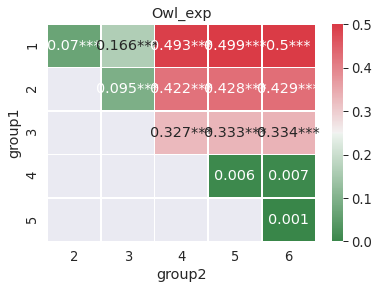

In [36]:
data,labels = get_tukey_data(exp='energy_gain_pure',org='krat')
cmap = sns.diverging_palette(133, 10, as_cmap=True)
hmap = sns.heatmap(data,cmap=cmap,linewidths=.5,vmin=0, vmax=0.5, annot=labels, fmt = '')

hmap.set_title('Owl_exp')

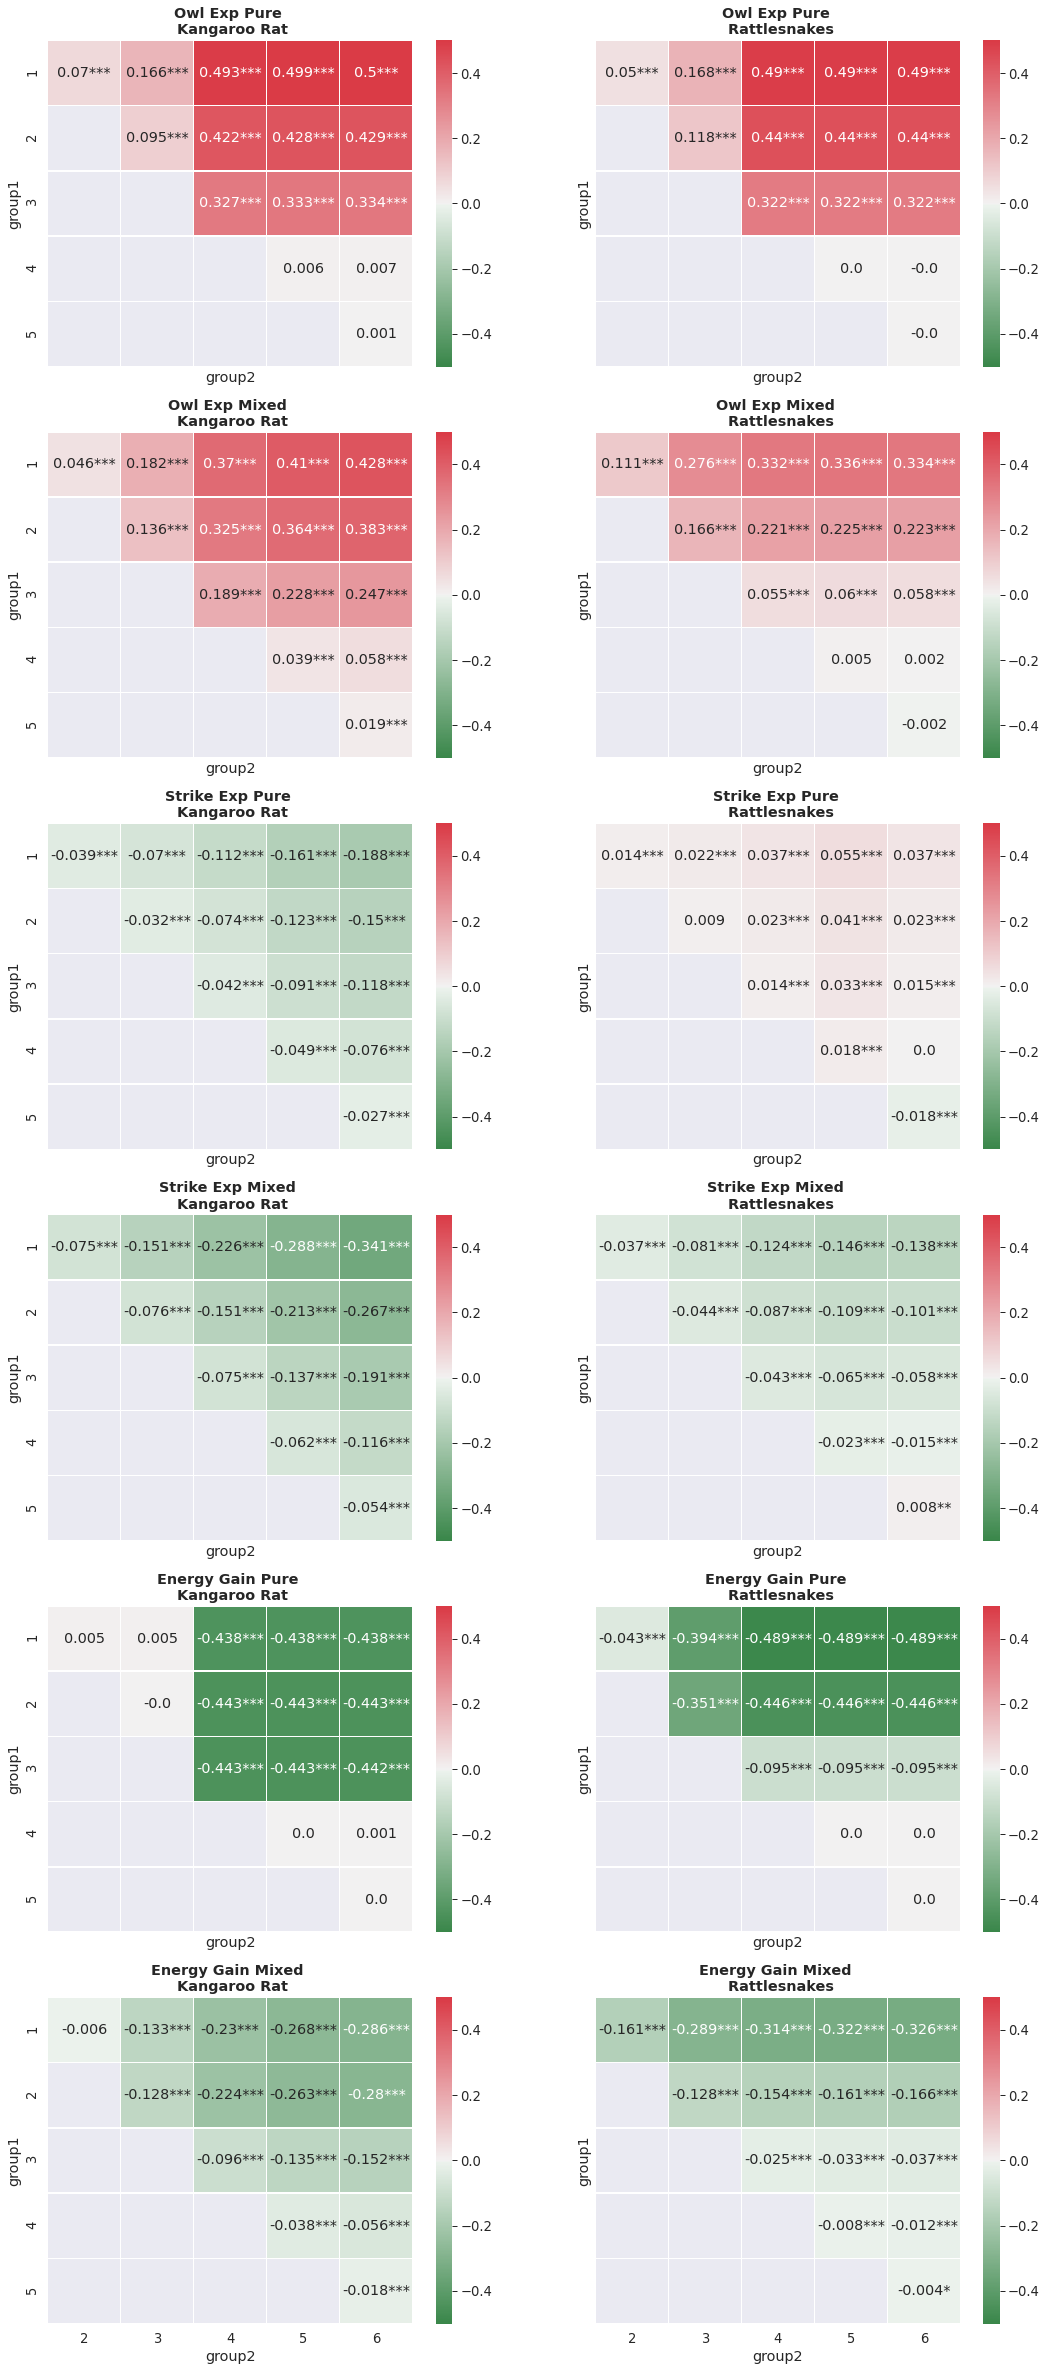

In [56]:
import matplotlib.pyplot as plt
experiment_names = ['owl_exp_pure',
                    'owl_exp_mixed',
                    'strike_exp_pure',
                    'strike_exp_mixed',
                    'energy_gain_pure',
                    'energy_gain_mixed',
                    ]

fig, axes = plt.subplots(len(experiment_names), 2, sharex=True,sharey=True, figsize=(18,42))

#sns.set(style="ticks")
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=1.5)

for i, title in enumerate(experiment_names):
    cmap = sns.diverging_palette(133, 10, as_cmap=True)
    
    krat_data,krat_labels = get_tukey_data(exp=title,org='krat')
    hmap = sns.heatmap(ax = axes[i,0],data= krat_data,cmap=cmap,linewidths=.5,vmin=-0.5, vmax=0.5, annot=krat_labels, fmt = '')
    hmap.set_title('{} \n Kangaroo Rat'.format(format_title(title)), fontweight='bold')
    
    snake_data,snake_labels = get_tukey_data(exp=title,org='snake')
    hmap_2 = sns.heatmap(ax = axes[i,1], data= snake_data,cmap=cmap,linewidths=.5,vmin=-0.5, vmax=0.5, annot=snake_labels, fmt = '')
    hmap_2.set_title('{} \n Rattlesnakes'.format(format_title(title)), fontweight='bold')